In [13]:
import os
import glob
from torch.utils.data import Dataset
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from sklearn.metrics import classification_report



root_dir = "/kaggle/input/mri-dataset-for-detection-and-analysis/NINS_Dataset/NINS_Dataset"

In [4]:
import os
import glob
from torch.utils.data import Dataset
from PIL import Image

class BrainMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.classes = []
        self.class_to_idx = {}

        for idx, folder_name in enumerate(sorted(os.listdir(root_dir))):
            folder_path = os.path.join(root_dir, folder_name)
            if os.path.isdir(folder_path):
                self.classes.append(folder_name)
                self.class_to_idx[folder_name] = idx
                for ext in ('jpg', 'jpeg', 'png'):
                    self.samples.extend(
                        [(img_path, idx) for img_path in glob.glob(os.path.join(folder_path, f'*.{ext}'))]
                    )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image, label


In [5]:


# Train Transform with augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Validation Transform
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset
full_dataset = BrainMRIDataset(root_dir=root_dir, transform=None)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Split datasets
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Set appropriate transforms
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

print("Total images:", len(full_dataset))
print("Number of classes:", len(full_dataset.classes))
print("Classes:", full_dataset.classes)


Total images: 5247
Number of classes: 38
Classes: ['Brain Atrophy', 'Brain Infection', 'Brain Infection with abscess', 'Brain Tumor', 'Brain Tumor (Ependymoma)', 'Brain Tumor (Hemangioblastoma  Pleomorphic xanthroastrocytoma  metastasis)', 'Brain tumor (Astrocytoma Ganglioglioma)', 'Brain tumor (Dermoid cyst craniopharyngioma)', 'Brain tumor - Recurrenceremnant of previous lesion', 'Brain tumor operated with ventricular hemorrhage', 'Cerebral Hemorrhage', 'Cerebral abscess', 'Encephalomalacia with gliotic change', 'Glioma', 'Hemorrhagic collection', 'Ischemic change  demyelinating plaque', 'Left Retro-orbital Haemangioma', 'Leukoencephalopathy with subcortical cysts', 'Malformation (Chiari I)', 'Microvascular ischemic change', 'Mid triventricular hydrocephalus', 'NMOSD  ADEM', 'Normal', 'Obstructive Hydrocephalus', 'Post-operative Status with Small Hemorrhage', 'Postoperative encephalomalacia', 'Small Vessel Diease Demyelination', 'Stroke (Demyelination)', 'Stroke (Haemorrhage)', 'Stro

In [6]:

class LNNLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LNNLayer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W_in = nn.Linear(input_size, hidden_size)
        self.W_hidden = nn.Linear(hidden_size, hidden_size)
        self.alpha = nn.Parameter(torch.ones(hidden_size))  # learnable time constants
        

    def forward(self, x):
        h = torch.zeros(x.size(0), self.hidden_size).to(x.device)
        outputs = []

        for t in range(x.size(1)):
            u = self.W_in(x[:, t, :]) + self.W_hidden(h)
            h = h + self.alpha * (torch.tanh(u) - h)
            outputs.append(h.unsqueeze(1))

        return torch.cat(outputs, dim=1)


In [7]:
class CNN_LSTM_LNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN_LSTM_LNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.lstm = nn.LSTM(input_size=64 * 56 * 56, hidden_size=128, batch_first=True)
        self.lnn = LNNLayer(input_size=128, hidden_size=64)
        self.dropout = nn.Dropout(p=0.5)  # Dropout added after LNN
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.cnn(x)             # [B, 64, 56, 56]
        x = x.view(batch_size, 1, -1)  # [B, T=1, F]
        x, _ = self.lstm(x)         # [B, T, 128]
        x = self.lnn(x)             # [B, T, 64]
        x = x[:, -1, :]             # Take last time step: [B, 64]
        x = self.dropout(x)         # Apply Dropout
        x = self.fc(x)              # Final classification
        return x


In [8]:
all_labels = [train_dataset.dataset[i][1] for i in train_dataset.indices]
unique_classes = np.unique(all_labels)

class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=all_labels)
weights_tensor = torch.zeros(len(full_dataset.classes), dtype=torch.float)
for i, cls in enumerate(unique_classes):
    weights_tensor[cls] = class_weights[i]


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM_LNN(num_classes=38).to(device)


criterion = nn.CrossEntropyLoss(weight=weights_tensor.to(device))  # ✅ Use weighted loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Optional scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


2025-08-02 16:08:02.322590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754150882.579737      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754150882.653376      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1: Train Loss 3.6478, Acc 0.0167 | Val Loss 3.6280, Acc 0.0476
Model saved.
Epoch 2: Train Loss 3.6161, Acc 0.0331 | Val Loss 3.5810, Acc 0.0276
Model saved.
Epoch 3: Train Loss 3.5450, Acc 0.0524 | Val Loss 3.4625, Acc 0.0762
Model saved.
Epoch 4: Train Loss 3.3765, Acc 0.1027 | Val Loss 3.3130, Acc 0.1524
Model saved.
Epoch 5: Train Loss 3.2158, Acc 0.1489 | Val Loss 3.1914, Acc 0.1819
Model saved.
Epoch 6: Train Loss 3.0378, Acc 0.2087 | Val Loss 3.0690, Acc 0.2029
Model saved.
Epoch 7: Train Loss 2.9057, Acc 0.2190 | Val Loss 2.9296, Acc 0.2257
Model saved.
Epoch 8: Train Loss 2.7305, Acc 0.2652 | Val Loss 2.7971, Acc 0.2495
Model saved.
Epoch 9: Train Loss 2.5630, Acc 0.2928 | Val Loss 2.6732, Acc 0.2676
Model saved.
Epoch 10: Train Loss 2.3788, Acc 0.3267 | Val Loss 2.5307, Acc 0.2886
Model saved.
Epoch 11: Train Loss 2.1994, Acc 0.3500 | Val Loss 2.4131, Acc 0.3162
Model saved.
Epoch 12: Train Loss 2.0217, Acc 0.3760 | Val Loss 2.2756, Acc 0.3667
Model saved.
Epoch 13: Tra

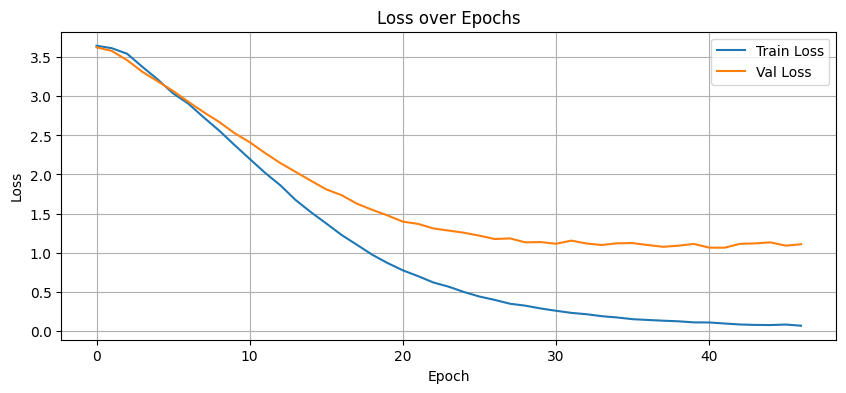

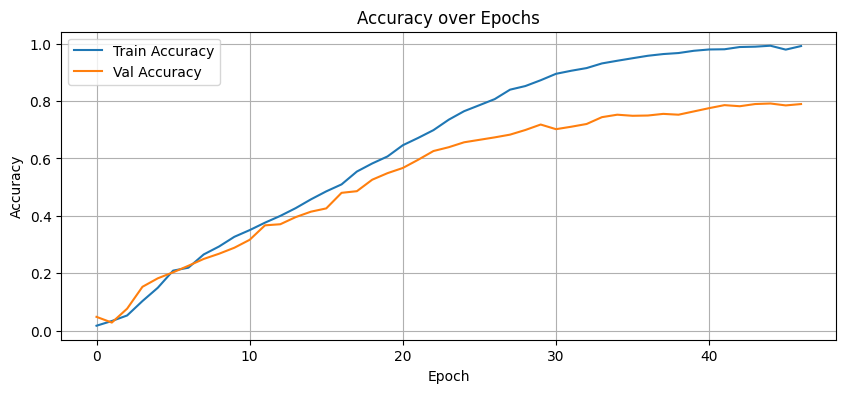

In [10]:
writer = SummaryWriter(log_dir="runs/brain_mri_cnn_lstm")
best_val_loss = float('inf')
patience = 5
counter = 0
save_path = "best_model.pth"

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(60):
    model.train()
    train_loss = 0.0
    correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = correct / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)

    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # TensorBoard
    writer.add_scalars("Loss", {"train": train_loss, "val": val_loss}, epoch)
    writer.add_scalars("Accuracy", {"train": train_acc, "val": val_acc}, epoch)

    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Acc {val_acc:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), save_path)
        print("Model saved.")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

    scheduler.step(val_loss)

writer.close()

# 📊 Plot graphs after training
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


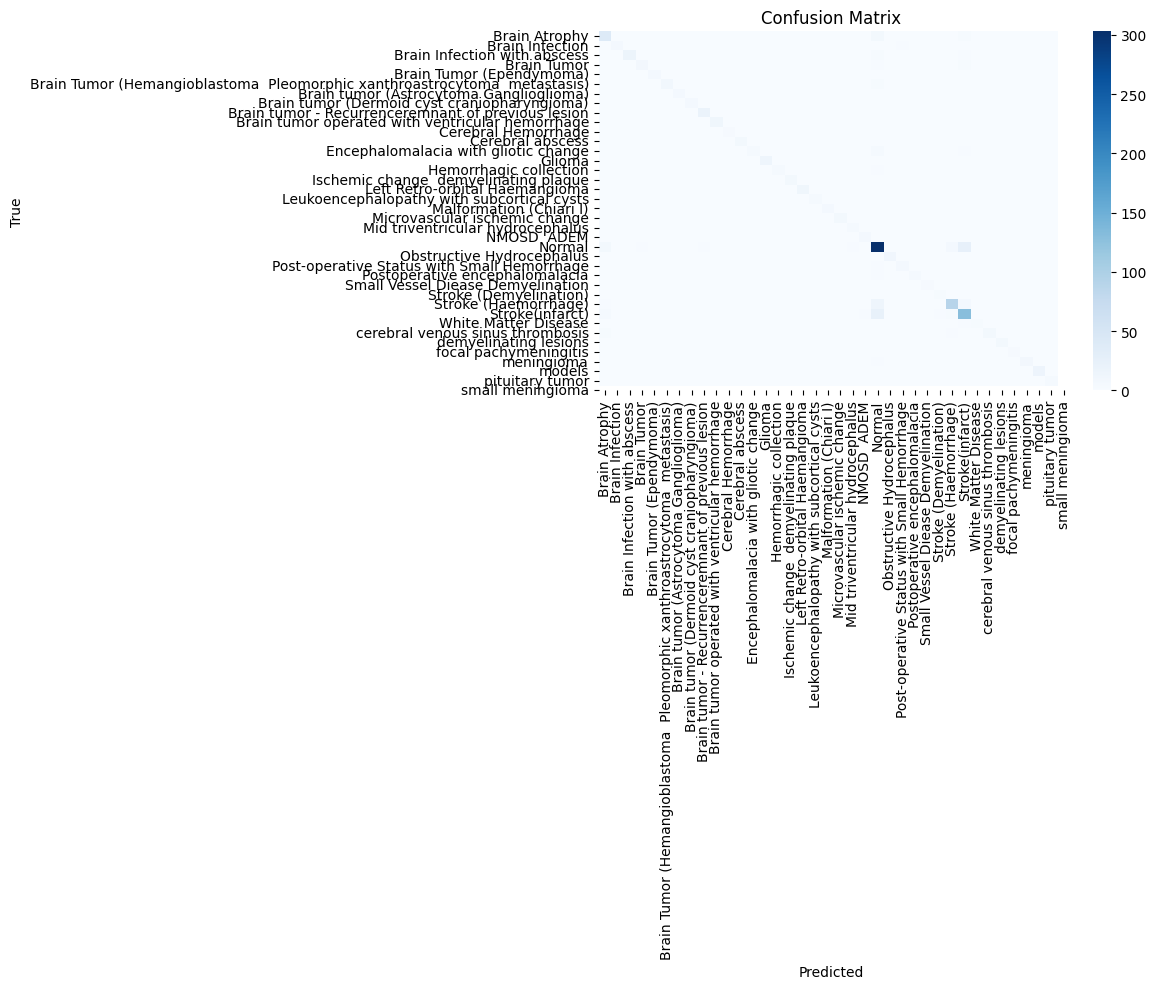

In [11]:
def plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(model, val_loader, full_dataset.classes)


In [12]:

def print_classification_report(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # ✅ Force inclusion of all 38 classes
    report = classification_report(
        all_labels,
        all_preds,
        labels=list(range(len(full_dataset.classes))),
        target_names=full_dataset.classes,
        zero_division=0
    )
    print(report)

print_classification_report(model, val_loader)


                                                                            precision    recall  f1-score   support

                                                             Brain Atrophy       0.66      0.73      0.69        55
                                                           Brain Infection       1.00      0.64      0.78        11
                                              Brain Infection with abscess       0.85      0.74      0.79        23
                                                               Brain Tumor       0.82      0.64      0.72        14
                                                  Brain Tumor (Ependymoma)       0.86      1.00      0.92         6
Brain Tumor (Hemangioblastoma  Pleomorphic xanthroastrocytoma  metastasis)       0.91      0.67      0.77        15
                                   Brain tumor (Astrocytoma Ganglioglioma)       1.00      0.60      0.75        10
                              Brain tumor (Dermoid cyst craniopharyngio